#Task5 Attempt2: Optimizing the diagrams using a curry re-write rule <br>
We noticed that many sentences include adjective + noun sentences and those adjectives are common between the two categories (food & IT) <br>
This might lead to ambiguity to the training model, so we used the curry re-write rule to help our poor model to not get ambigouis between: <br>
experienced chef     & experienced programmer <br>


In [5]:
# import image module
from IPython.display import Image

# get the image
Image(url="QNLP_stages.drawio.png", width=900, height=500)

In [2]:
# import image module
from IPython.display import Image

# get the image
Image(url="Similarity_matrix.drawio.png", width=500, height=500)


In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
import numpy as np

BATCH_SIZE = 50
EPOCHS = 120
SEED = 2

In [4]:
def read_data(filename):
    labels, sentences1, sentences2 = [], [], []
    with open(filename) as f:
        for line in f:
            split_list = line.split(",")
            t = int(split_list[2])
            labels.append(t)
            sentences1.append(split_list[0])
            sentences2.append(split_list[1])
    return labels, sentences1, sentences2

all_labels, all_sentences1, all_sentences2 = read_data('MC1.TXT')
all_data = list(zip(all_sentences1[0:80], all_sentences2[0:80]))

train_labels, train_data1, train_data2 = all_labels[0: 80], all_sentences1[0: 80], all_sentences2[0: 80]
test_labels, test_data1, test_data2 = all_labels[80: 100], all_sentences1[80: 100], all_sentences2[80: 100]
test_data =  list(zip(all_sentences1[80:100], all_sentences2[80:100]))
print(len(train_labels))


80


In [5]:
from lambeq import BobcatParser

parser = BobcatParser(verbose='text')

raw_train_sentences1_diagrams = parser.sentences2diagrams(train_data1)
raw_test_sentences1_diagrams = parser.sentences2diagrams(test_data1)
raw_train_sentences2_diagrams = parser.sentences2diagrams(train_data2)
raw_test_sentences2_diagrams = parser.sentences2diagrams(test_data2)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


In [6]:
from lambeq import remove_cups

train_s1_diagrams = [remove_cups(diagram) for diagram in raw_train_sentences1_diagrams]

test_s1_diagrams = [remove_cups(diagram) for diagram in raw_test_sentences1_diagrams]

train_s2_diagrams = [remove_cups(diagram) for diagram in raw_train_sentences2_diagrams]

test_s2_diagrams = [remove_cups(diagram) for diagram in raw_test_sentences2_diagrams]

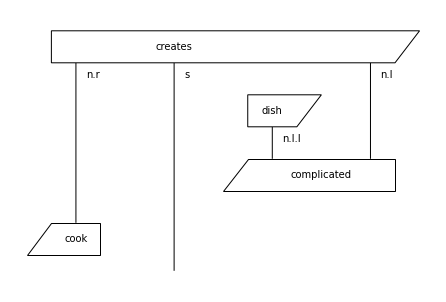

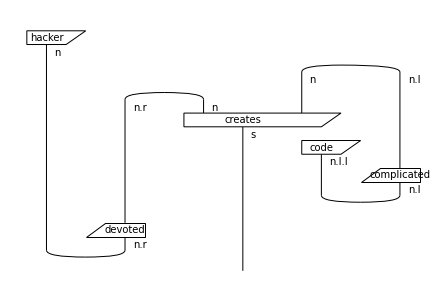

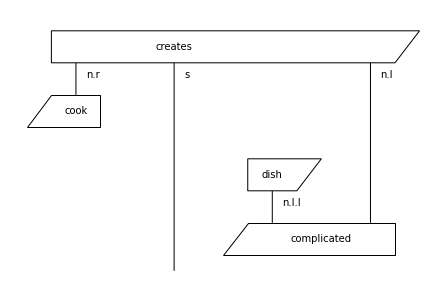

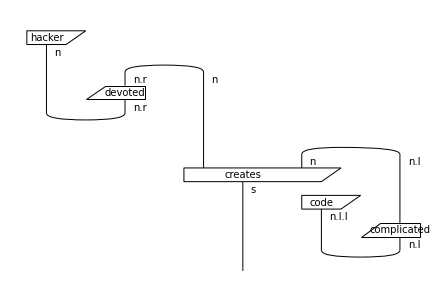

In [7]:
from lambeq import Rewriter

# Apply rewrite rule for prepositional phrases
curry_functor = Rewriter(['curry'])
curried_s1_train_diagrams = [(diagram) for diagram in train_s1_diagrams]
curried_s1_test_diagrams = [curry_functor(diagram) for diagram in test_s1_diagrams ]
curried_s2_train_diagrams = [curry_functor(diagram) for diagram in train_s2_diagrams]
curried_s2_test_diagrams = [curry_functor(diagram) for diagram in test_s2_diagrams]
curried_s1_train_diagrams[0].draw()
curried_s2_train_diagrams[2].draw()
normalised_s1_train_diagrams = [diagram.normal_form() for diagram in curried_s1_train_diagrams]
normalised_s1_test_diagrams = [diagram.normal_form() for diagram in curried_s1_test_diagrams]
normalised_s2_train_diagrams = [diagram.normal_form() for diagram in curried_s2_train_diagrams]
normalised_s2_test_diagrams = [diagram.normal_form() for diagram in curried_s2_test_diagrams]
normalised_s1_train_diagrams[0].draw()
normalised_s2_train_diagrams[2].draw()

Now looking at the above diagrams after applying the curried method, the word comlpicated was once associated with dish and once associated with code so it shall not be ambigouis anymore <br>
Let's see how our model would be happy with that <br>

In [8]:
from lambeq import AtomicType, IQPAnsatz

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=2, n_single_qubit_params=3)

train_s1_circuits = [ansatz(diagram) for diagram in normalised_s1_train_diagrams]

test_s1_circuits = [ansatz(diagram) for diagram in normalised_s1_test_diagrams]

train_s2_circuits = [ansatz(diagram) for diagram in normalised_s2_train_diagrams]

test_s2_circuits = [ansatz(diagram) for diagram in normalised_s2_test_diagrams]

train_circuits = train_s1_circuits + train_s2_circuits
test_circuits =  test_s1_circuits + test_s2_circuits
all_circuits_lst = train_circuits + test_circuits
all_train_data = list(zip((list(zip(train_s1_circuits, train_s2_circuits))), train_labels))
all_test_data =  list(zip(list(zip(test_s1_circuits, test_s2_circuits)), test_labels))
all_data = all_train_data + all_test_data

In [9]:
from pytket.circuit.display import render_circuit_jupyter

tket_circuit = train_circuits[17].to_tk()

render_circuit_jupyter(tket_circuit)

In [10]:
from lambeq import NumpyModel, Model
def cos_sim_2d(x, y):
        norm_x = x / np.linalg.norm(x, axis=1, keepdims=True)
        norm_y = y / np.linalg.norm(y, axis=1, keepdims=True)
        return np.matmul(norm_x, norm_y.T)
class ClassificationModel(NumpyModel): 
    right_prediction = 0
    wrong_prediction = 0
    def forward(self, Mytuple):
        a = np.array(Mytuple)
        y_hat = []
        output1 = NumpyModel.get_diagram_output(self, diagrams=a[:, 0])
        output2 = NumpyModel.get_diagram_output(self, diagrams=a[:, 1])
        #output1.reshape((1, 4))
        result = [
        idx for idx, tup in enumerate(all_data) if tup[0] == zip(a[:, 0], a[:, 1])
        ]
        if len(result) > 0:
            for idx in result:
                truth_value.append(all_data[idx][1])
        #output2.reshape((1, 4))
        similarity_matrix = cos_sim_2d(output1, output2)
        y_hat = np.diagonal(similarity_matrix)
        return np.array(y_hat)


In [11]:

#Model.initialize_weights()
train_circuits2 = list(zip(train_s1_circuits , train_s2_circuits))
test_circuits2 = list(zip(test_s1_circuits , test_s2_circuits))
all_circuits = train_circuits2 + test_circuits2
sentence1_circuits= [ seq[0] for seq in all_circuits]
sentence2_circuits= [ seq[1] for seq in all_circuits]
#all_circuits = sentence1_circuits + sentence2_circuits
model = ClassificationModel.from_diagrams(all_circuits_lst, use_jit=True)


In [12]:
import numpy
epsilon=numpy.finfo('float').eps
loss = lambda y_hat, y: -np.sum(y * np.log(y_hat + epsilon)) / len(y)  # binary cross-entropy lossةخيثم
acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting

In [13]:
from lambeq import QuantumTrainer, SPSAOptimizer

trainer = QuantumTrainer(
    model,
    epochs=EPOCHS,
    loss_function=loss,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    verbose = 'text',
    seed=0
)

In [14]:
from lambeq import Dataset

train_dataset = Dataset(
            train_circuits2,
            train_labels,
            batch_size=BATCH_SIZE)

val_dataset = Dataset(test_circuits2, test_labels, shuffle=False)
print(len(test_labels))

20


In [15]:
trainer.fit(train_dataset, val_dataset, logging_step=12)

Epoch 1:    train/loss: 0.1099   valid/loss: 0.0869   train/acc: 0.2687   valid/acc: 0.2250
Epoch 12:   train/loss: 0.0630   valid/loss: 0.0903   train/acc: 0.2812   valid/acc: 0.2250
Epoch 24:   train/loss: 0.0611   valid/loss: 0.1183   train/acc: 0.2750   valid/acc: 0.2000
Epoch 36:   train/loss: 0.0520   valid/loss: 0.1377   train/acc: 0.2750   valid/acc: 0.2000
Epoch 48:   train/loss: 0.0520   valid/loss: 0.1270   train/acc: 0.2750   valid/acc: 0.2000
Epoch 60:   train/loss: 0.0451   valid/loss: 0.1216   train/acc: 0.2750   valid/acc: 0.2000
Epoch 72:   train/loss: 0.0455   valid/loss: 0.1225   train/acc: 0.2750   valid/acc: 0.2250
Epoch 84:   train/loss: 0.0365   valid/loss: 0.1155   train/acc: 0.2750   valid/acc: 0.2250
Epoch 96:   train/loss: 0.0514   valid/loss: 0.1129   train/acc: 0.2750   valid/acc: 0.2250
Epoch 108:  train/loss: 0.0431   valid/loss: 0.1126   train/acc: 0.2750   valid/acc: 0.2000
Epoch 120:  train/loss: 0.0368   valid/loss: 0.1094   train/acc: 0.2750   valid/

Test accuracy: 0.225


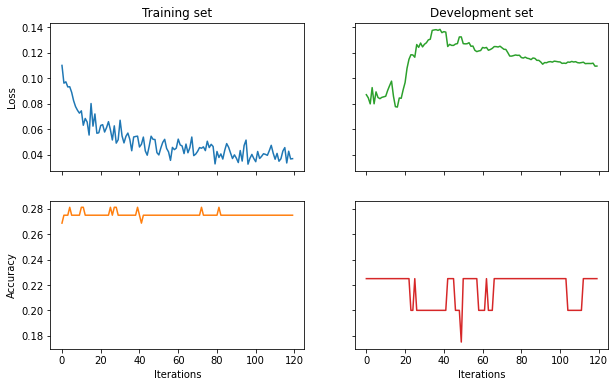

In [16]:
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(trainer.train_results['acc'], color=next(colours))
ax_tr.plot(trainer.val_costs, color=next(colours))
ax_br.plot(trainer.val_results['acc'], color=next(colours))

test_acc = acc(model(test_circuits2), test_labels)
print('Test accuracy:', test_acc)